# Linear Algebra with Transformers: Eigenvalue Problem


In this notebook we explore ideas from François Charton's paper  
[**"Linear Algebra with Transformers"**](https://arxiv.org/abs/2112.01898).

We focus on **how transformer can be applied to a nontrivial linear algebra task**: computing eigenvalues of symmetric matrices.

---

### What we will cover
1. **Motivation from the paper** – why linear algebra can be reframed as a sequence-to-sequence learning problem.  
2. **The eigenvalue task** – input: symmetric matrix; output: sorted eigenvalues.  
3. **Encoding and data generation** – how to represent matrices and eigenvalues as tokens for training.  
4. **Small-scale experiment** – training a toy Transformer model on generated data.  
5. **Evaluation and results** – comparing predicted vs. true eigenvalues, and discussing limitations.  
6. **Insights and wrap-up** – how this connects back to the broader claims of the paper.


## Can a **language model** learn **linear algebra**?  
Surprisingly, yes! 🤯

In 2021, François Charton asked exactly this question in the paper  
[**Linear Algebra with Transformers**](https://arxiv.org/abs/2112.01898).  

Instead of teaching a model to translate English to French,  
he trained it to **“translate” a matrix into its eigenvalues, determinant, or inverse**.  
The result: Transformers — designed for words — turned out to be powerful tools for **mathematics**.  

---

👉 In this notebook, we’ll explore this idea through a **hands-on puzzle**:  
Can a Transformer learn to solve the **eigenvalue problem** for symmetric matrices?

We’ll keep things playful:
* Start with a puzzle you can try by hand.  
* Show how a Transformer can treat matrices as sequences (like sentences).  
* Train a tiny model to “translate” matrices into their eigenvalues.  
* Reflect on what this tells us about Transformers and math.

---

❓ **Guiding question for you:**  
If you were handed a random symmetric $3 \times 3$ matrix,  
how would *you* try to guess its eigenvalues?  

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt

import math
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
np.random.seed(42)

## The Eigenvalue Challenge

Before we bring in Transformers, let’s set up the mathematical puzzle.  

A **symmetric matrix** is a square matrix equal to its transpose:
$$
A = A^\top
$$

Symmetric matrices are nice because:
* Their eigenvalues are always **real numbers**.  
* Their eigenvectors form an **orthogonal basis**.  



### Mini-puzzle 🧩
Here’s a random $3 \times 3$ symmetric matrix:  

👉 **Your challenge:** Can you guess its eigenvalues just by looking at it?  
(It’s not easy by hand — that’s the point!)

In [ ]:
# Generate a random symmetric 3x3 matrix
M = np.random.randint(-5, 6, size=(3, 3))
M = (M + M.T) // 2  # symmetrize

# Compute eigenvalues
eigvals, eigvecs = np.linalg.eigh(M)

print("Here is your matrix:")
print(M)

# Add slider/input for students to guess eigenvalues
import ipywidgets as widgets
from IPython.display import display

guesses = [widgets.FloatText(description=f"λ{i+1}", value=0.0) for i in range(3)]
button = widgets.Button(description="Check my guess")

out = widgets.Output()

def check_eigenvals(b):
    with out:
        out.clear_output()
        print("Your guesses:", [g.value for g in guesses])
        print("Actual eigenvalues:", np.round(eigvals, 2))

display(*guesses, button, out)
button.on_click(check_eigenvals)

Here is your matrix:
[[ 1  0  4]
 [ 0 -1 -1]
 [ 4 -1  1]]


FloatText(value=0.0, description='λ1')

FloatText(value=0.0, description='λ2')

FloatText(value=0.0, description='λ3')

Button(description='Check my guess', style=ButtonStyle())

Output()

## Why Transformers?

Okay… but what do Transformers have to do with eigenvalues? 🤔  

Think of it this way:

- A **matrix** is just a grid of numbers.  
- We can **flatten** it row by row into a sequence of tokens:  
  $$
  [a_{11}, a_{12}, a_{13}, a_{21}, a_{22}, \dots, a_{33}]
  $$
- That sequence is like a **sentence**.  

Now imagine a strange translation task:  
- **Input sentence** = the numbers of the matrix.  
- **Output sentence** = its eigenvalues.  

---

###  Analogy
- Just like a Transformer can translate *“Bonjour, je m’appelle Alice”* → *“Hello, my name is Alice”*,  
- It might also translate *“[2, 1, 1, 2, 1, 3, 1, 3, 4]”* → *“[0.2, 2.5, 5.3]”*.  

---

The key idea:  
> We’re not teaching the Transformer linear algebra rules explicitly.  
> We’re just giving it **lots of examples** and letting it discover the hidden structure by itself.

That’s the spirit of Charton’s paper — **language models can learn math tasks if you phrase them like translation problems.**

## Data as Sequences

To train a Transformer, we need to phrase everything as **sequences**.

- **Input sequence:** the entries of a symmetric matrix, flattened row by row.  
- **Output sequence:** its eigenvalues, sorted for consistency.  

This way, the problem looks like machine translation:  
$$
\text{[matrix entries]} \;\;\;\longrightarrow\;\;\; \text{[eigenvalues]}
$$

---

### Example

Matrix:
$$
\begin{bmatrix}
2 & 1 & 1 \\
1 & 2 & 1 \\
1 & 1 & 3
\end{bmatrix}
$$

Input sequence: `[2, 1, 1, 1, 2, 1, 1, 1, 3]`  
Output sequence: `[1.0, 2.0, 4.0]`  

In [ ]:
def make_symmetric_matrix(n: int, low: int = -5, high: int = 5):
    """Generate a random symmetric n×n matrix with integer entries."""
    A = np.random.randint(low, high+1, size=(n, n))
    return (A + A.T) // 2  # force symmetry

def matrix_to_sequence(M: np.ndarray):
    """Flatten matrix row by row into a sequence of ints."""
    return M.flatten().tolist()

def eigen_to_sequence(M: np.ndarray):
    """Compute sorted eigenvalues as output sequence."""
    vals = np.linalg.eigvalsh(M)  # fast for symmetric matrices
    return np.round(np.sort(vals), 3).tolist()

# Example: make dataset of small symmetric matrices
def generate_dataset(num_samples=5, n=3):
    data = []
    for _ in range(num_samples):
        M = make_symmetric_matrix(n)
        x_seq = matrix_to_sequence(M)
        y_seq = eigen_to_sequence(M)
        data.append((x_seq, y_seq))
    return data

# Try it out
dataset = generate_dataset(num_samples=3, n=3)
for i, (x, y) in enumerate(dataset):
    print(f"Sample {i+1}")
    print("Input sequence (matrix):", x)
    print("Output sequence (eigenvalues):", y)
    print("---")

Sample 1
Input sequence (matrix): [5, 2, 2, 2, -2, -1, 2, -1, 0]
Output sequence (eigenvalues): [-3.273, 0.254, 6.019]
---
Sample 2
Input sequence (matrix): [-1, -2, -2, -2, -4, 1, -2, 1, 0]
Output sequence (eigenvalues): [-5.0, -2.236, 2.236]
---
Sample 3
Input sequence (matrix): [3, 0, 3, 0, 4, -3, 3, -3, 3]
Output sequence (eigenvalues): [-1.026, 3.493, 7.533]
---


In [6]:
!git clone https://github.com/facebookresearch/lawt.git
%cd lawt

Cloning into 'lawt'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 42 (delta 2), reused 1 (delta 1), pack-reused 25 (from 1)
Receiving objects: 100% (42/42), 57.13 KiB | 2.12 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/lawt
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Obtaining file:///content/lawt
ERROR: file:///content/lawt does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


## d

#END

In the paper https://arxiv.org/pdf/2112.01898) the following problems were considered:

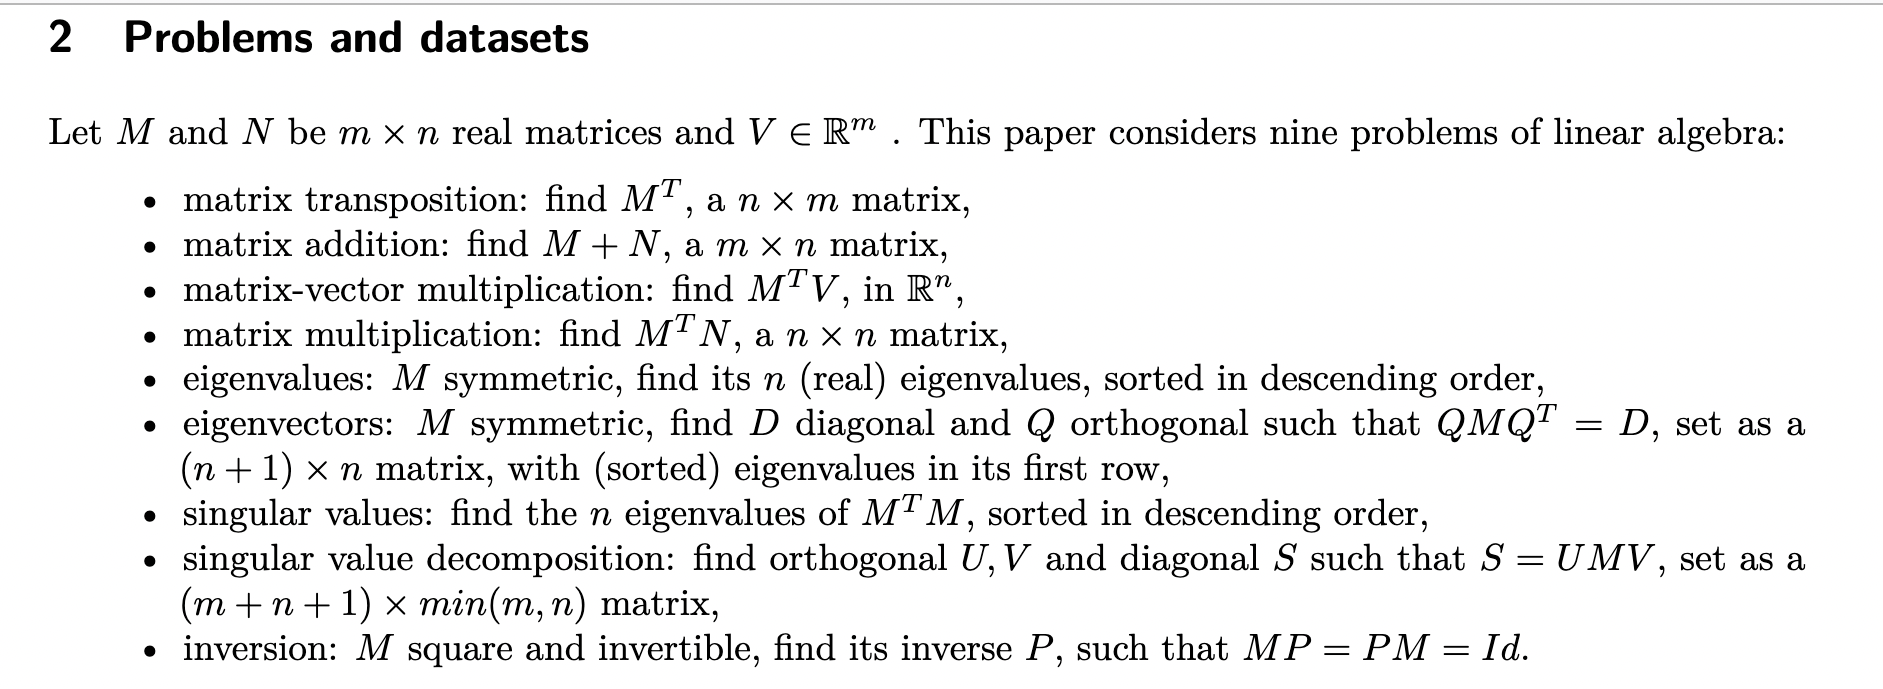

We will apply the Transformer model to the <font color='red'>**eigenvalue problem**</font>. First, let us load model parameters from https://github.com/facebookresearch/LAWT

In [ ]:
import torch
!wget https://dl.fbaipublicfiles.com/LAWT/eigenvalue_semicircle.tar.gz
!tar -xzvf eigenvalue_semicircle.tar.gz

--2025-05-05 21:02:27--  https://dl.fbaipublicfiles.com/LAWT/eigenvalue_semicircle.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.118, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491385621 (469M) [application/x-tar]
Saving to: ‘eigenvalue_semicircle.tar.gz’

eigenvalue_semicirc 100%[===================>] 468.62M  34.7MB/s    in 15s     

2025-05-05 21:02:43 (30.7 MB/s) - ‘eigenvalue_semicircle.tar.gz’ saved [491385621/491385621]

best-valid_numeric_beam_acc.pth
params.pkl
train.log


# 1. Encoding

We need to **encode** our matrices. Four encoding types are used in https://arxiv.org/pdf/2112.01898

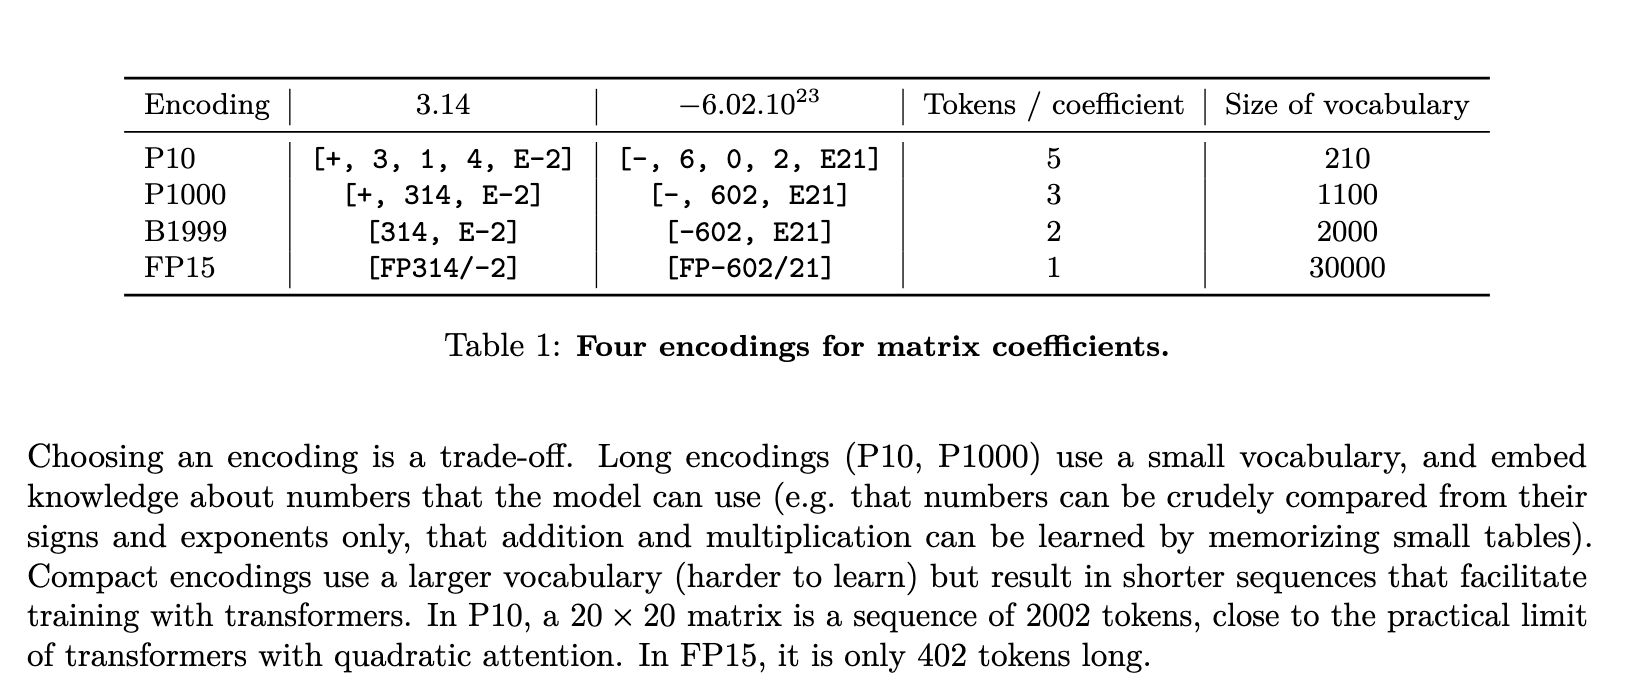

## 1.1 Encoder and Decoder parameters

The loaded parameters specify the encodings used:

*   FP15 for input,
*   P1000 for output.




In [ ]:
import torch

# Load the model parameters and map to the CPU
state_dict = torch.load('best-valid_numeric_beam_acc.pth', map_location=torch.device('cpu'))
print(state_dict.keys())
print()

loaded_params = state_dict['params']
loaded_params["input_encoding"], loaded_params["output_encoding"]

dict_keys(['epoch', 'n_total_iter', 'best_metrics', 'best_stopping_criterion', 'params', 'encoder', 'decoder', 'optimizer', 'scaler'])



('FP15,2,16', 'float,2,1000')

The following function is needed for embedding the encodings.

In [ ]:
def Embedding(num_embeddings, embedding_dim, padding_idx=None):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)
    return m

### 1.1.1 Encoder

The encoder is implemented as an abstract class. Abstract functions allow for derived class definitions, enabling the creation of various encoder implementations. The matrix encoding process is demonstrated in the example below.

We use the code from https://github.com/facebookresearch/LAWT/blob/main/src/envs/encoders.py

The encoder code is extensive but straightforward. <font color='red'>Feel free to skip it; focus on the usage examples below</font>.

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import math

class Encoder(ABC):
    """
    Base class for encoders, encodes and decodes matrices
    abstract methods for encoding/decoding numbers
    """
    def __init__(self, max_dimension, precision):
        self.max_encoder_dimension = max_dimension
        self.float_precision = precision
        self.symbols = ["V" + str(i) for i in range(1, self.max_encoder_dimension + 1)]
        self.limit = -1

    @abstractmethod
    def write_float(self, val):
        pass

    @abstractmethod
    def parse_float(self, lst):
        pass

    def encode(self, matrix):
        lst = []
        l, c = np.shape(matrix)
        lst.append("V" + str(l))
        lst.append("V" + str(c))
        for line in matrix:
            for val in line:
                lst.extend(self.write_float(val))
        return lst

    def decode(self, lst):
        if len(lst) < 2 or lst[0][0] != "V" or lst[1][0] != "V":
            return None
        nr_lines = int(lst[0][1:])
        nr_cols = int(lst[1][1:])
        h = lst[2:]
        m = np.zeros((nr_lines, nr_cols), dtype=float)
        for i in range(nr_lines):
            for j in range(nr_cols):
                val, pos = self.parse_float(h)
                if np.isnan(val):
                    return None
                h = h[pos:]
                m[i, j] = val
        return m

### 1.1.2 FP15 encoder

In [ ]:
class FPSymbol(Encoder):
    def __init__(self, params, precision, max_exponent):
        super().__init__(params["max_encoder_dimension"], precision)
        self.max_exponent = max_exponent
        assert (self.float_precision + self.max_exponent) % 2 == 0
        self.symbols.extend(["NaN", "-NaN"])
        dig = 10 ** self.float_precision
        self.logrange = (self.float_precision + self.max_exponent) // 2
        self.base = 10 ** (self.logrange - self.float_precision)
        self.limit = 10 ** self.logrange
        self.output_length = 1
        # less than 1
        self.symbols.extend(["N" + str(i) + "e0" for i in range(-dig + 1, dig)])
        for i in range(self.max_exponent):
            for j in range(1, 10):
                for k in range(dig):
                    self.symbols.append("N" + str(j * dig + k) + "e" + str(i))
                    self.symbols.append("N-" + str(j * dig + k) + "e" + str(i))

    def write_float(self, value):
        if abs(value) > self.limit:
            return ["NaN"] if value > 0 else ["-NaN"]
        sign = -1 if value < 0 else 1
        v = abs(value) * self.base
        if v == 0:
            return ["N0e0"]
        e = int(math.log10(v))
        if e < 0:
            e = 0
        m = int(v * (10 ** (self.float_precision - e)) + 0.5)
        if m == 0:
            sign = 1
        if m == 1000:
            m = 100
            e += 1
        if e >= self.max_exponent:
            return ["NaN"] if value > 0 else ["-NaN"]
        pref = "N" if sign == 1 else "N-"
        return [pref + str(m) + "e" + str(e)]

    def parse_float(self, lst):
        if len(lst) == 0:
            return np.nan, 0
        if lst[0] == "NaN":
            return self.limit, 1
        if lst[0] == "-NaN":
            return -self.limit, 1
        if lst[0][0] != "N":
            return np.nan, 1
        m, e = lst[0][1:].split("e")
        v = (int(m) * (10 ** int(e))) / self.limit
        return v, 1

### 1.1.3 P1000 encoder

In [ ]:
class Positional(Encoder):
    def __init__(self, params, prec, base_int):
        super().__init__(params["max_encoder_dimension"], prec)
        self.base = base_int

        self.symbols.extend([str(i) for i in range(self.base)])
        self.symbols.extend(['E' + str(i) for i in range(-100, 101)])
        self.limit = 10.0 ** 101
        # WARNING adjust this at some point
        self.output_length = 5 if base_int == 10 else 3

    def gobble_int(self, lst):
        res = 0
        i = 0
        for x in lst:
            if not (x.isdigit()):
                break
            res = res * self.base + int(x)
            i += 1
        return res, i

    def write_posint(self, value):
        if value == 0:
            return ["0"]
        seq = []
        v = value
        while v > 0:
            seq.append(str(v % self.base))
            v = v // self.base
        return seq[::-1]

    def write_float(self, value):
        """
        Write a float number
        """
        precision = self.float_precision
        assert value not in [-np.inf, np.inf]
        m, e = (f"%.{precision}e" % abs(value)).split("e")
        i, f = m.split(".")
        i = i + f
        ipart = int(i)
        fpart = 0
        expon = int(e) - precision
        if expon < -100:
            ipart = 0
            fpart = 0
        if ipart == 0 and fpart == 0:
            value = 0.0
            expon = 0
        res = ["+"] if value >= 0.0 else ["-"]
        res = res + self.write_posint(ipart)
        if fpart != 0:
            res.append('.')
            res = res + self.write_posint(fpart)
        return res + ["E" + str(expon)]

    def parse_float(self, lst):
        """
        Parse a list that starts with a float.
        Return the float value, and the position it ends in the list.
        """
        if len(lst) < 2 or lst[0] not in ["+", "-"]:
            return np.nan, 0
        sign = -1 if lst[0] == "-" else 1
        pos = 1
        mant, i = self.gobble_int(lst[pos:])
        if i == 0:
            return np.nan, pos
        pos += i
        if len(lst) > pos and lst[pos] == ".":
            pos += 1
            base_mul = 1.0
            mul, i = self.gobble_int(lst[pos:])
            mul *= base_mul
            mul /= 10 ** self.float_precision
            pos += i
            mant += mul
        mant *= sign
        if len(lst) > pos and lst[pos] == "10^":
            pos += 1
            if lst[pos] not in ["+", "-"]:
                return np.nan, pos
            signexp = -1 if lst[pos] == "-" else 1
            pos += 1
            exp, i = self.gobble_int(lst[pos:])
            exp *= signexp
            if i == 0:
                return np.nan, pos
            pos += i
        elif len(lst) > pos and lst[pos][0] == "E":
            exp = int(lst[pos][1:])
            pos += 1
        else:
            exp = 0
        try:
            value = mant * (10 ** exp)
        except Exception:
            return np.nan, pos
        return value, pos

### 1.1.4 Examples of encodings

The next example demonstrates the encoding.

In [ ]:
def encode_decode_matrix(encoder):
  # Create a 2x2 matrix
  a, b = 2, 3
  matrix = 20 * np.random.rand(a, b) - 10  # Example matrix with random values in [-10,10]
  print("Original Matrix:")
  print(matrix)

  # Encode the matrix
  encoded_matrix = encoder.encode(matrix)
  print("\nEncoded Matrix:")
  print(encoded_matrix)

  # Decode the matrix
  decoded_matrix = encoder.decode(encoded_matrix)
  print("\nDecoded Matrix:")
  print(decoded_matrix)

Encoder:

In [ ]:
# Initialize the encoder
encoder_params = {
    "max_encoder_dimension": 100
}

encoder_prec = 2
encdoder_max_exponent = 16
input_encoder = FPSymbol(params=encoder_params, precision=encoder_prec, max_exponent=encdoder_max_exponent)

encode_decode_matrix(input_encoder)

Original Matrix:
[[ 4.65522017 -3.23833227  8.45465944]
 [ 2.75299227 -7.52992013 -9.7138643 ]]

Encoded Matrix:
['V2', 'V3', 'N466e7', 'N-324e7', 'N845e7', 'N275e7', 'N-753e7', 'N-971e7']

Decoded Matrix:
[[ 4.66 -3.24  8.45]
 [ 2.75 -7.53 -9.71]]


Decoder:

In [ ]:
decoder_params = {
    "max_encoder_dimension": 100
}
decoder_prec =  2
decoder_base_int = 1000
output_encoder = Positional(params=decoder_params, prec=decoder_prec, base_int=decoder_base_int)

encode_decode_matrix(output_encoder)

Original Matrix:
[[ 6.25425254 -5.00499789 -5.67660874]
 [ 1.09353559 -8.37766118 -1.66388686]]

Encoded Matrix:
['V2', 'V3', '+', '625', 'E-2', '-', '500', 'E-2', '-', '568', 'E-2', '+', '109', 'E-2', '-', '838', 'E-2', '-', '166', 'E-2']

Decoded Matrix:
[[ 6.25 -5.   -5.68]
 [ 1.09 -8.38 -1.66]]


# 2. Transformer

The **Transformer** architecture includes an encoder and a decoder.

*   The **encoder** consists of N encoder layers (6 in the original paper, but this is adjustable).
*   The **decoder** contains M decoder layers (for simplicity of description we assume $M=N$, but in the example below $N=6, M=1$).

There are also connections between encoder layers and decoder layers. For clarity, the figure below should display "encoder layers" and "decoder layers," instead of the less specific "encoders" and "decoders".


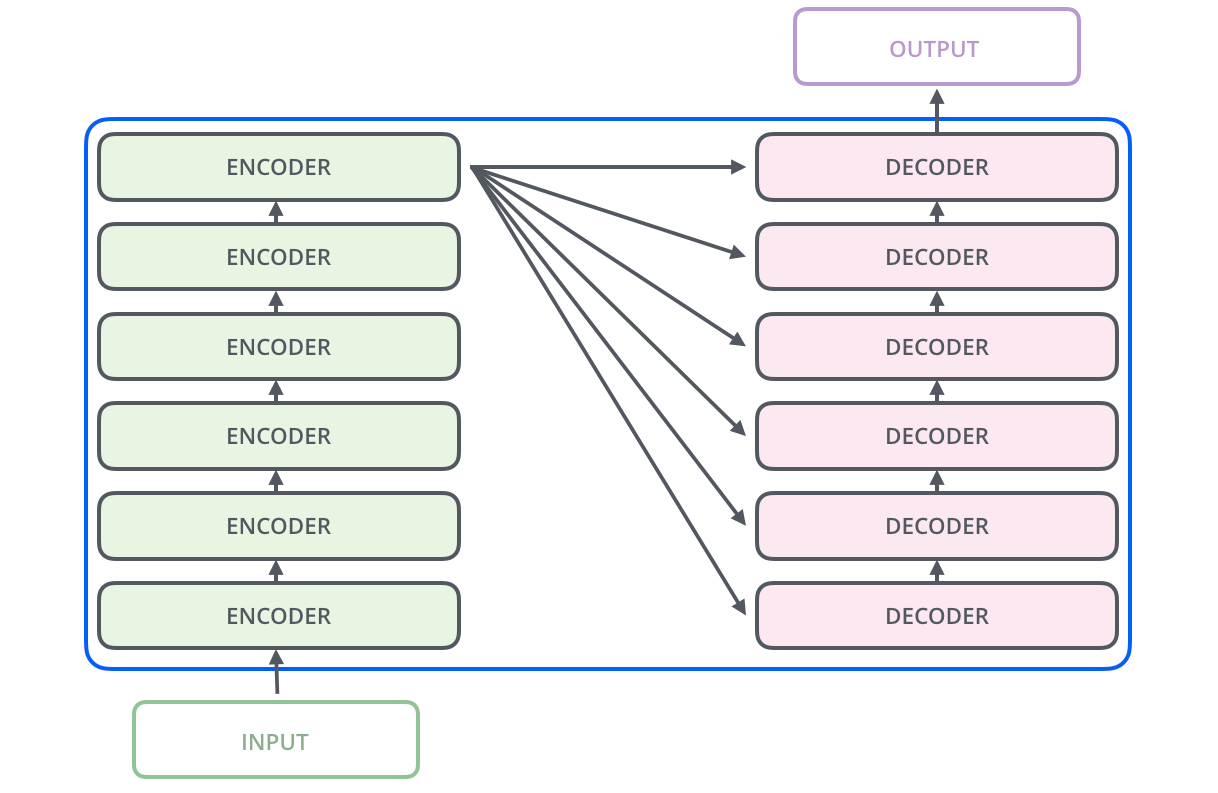

**Encoder layers** in the Transformer have identical structures but distinct weights. Each encoder layer consists of

*  a **self-attention layer**, which processes input words in context,
*  followed by a position-wise **feed-forward network**.

The **decoder** mirrors this, adding between them an **attention layer** to focus on relevant encoder outputs. "Encoder-Decoder Attention" in the figure below is commonly referred to as **Cross-Attention**.

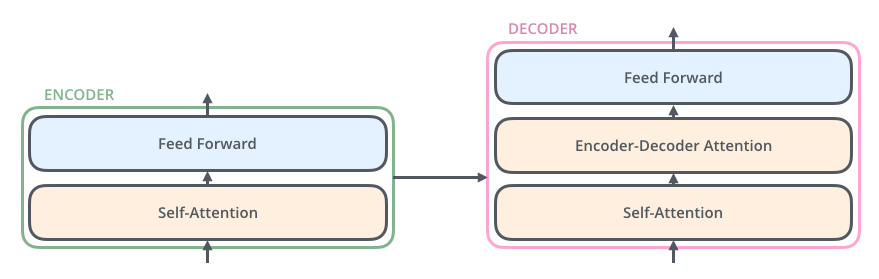

This is a simplified overview. In practice, layers include **normalization** and **residual connections** for stability. <font color='red'>See "Transformer Layers" Section below for details.</font>

In the example below the FNN architecture follows a simple pattern: $$\text{Linear } + \text{ ReLU } + \text{ Linear } + \text{ Dropout}.$$

In practice, FNNs can have more complex architectures.






In [ ]:
class TransformerFFN(nn.Module):
    def __init__(self, in_dim, dim_hidden, out_dim, dropout):
        super().__init__()
        self.dropout = dropout
        self.act = F.relu
        self.lin1 = nn.Linear(in_dim, dim_hidden)
        self.lin2 = nn.Linear(dim_hidden, out_dim)

    def forward(self, input):
        x = self.lin1(input)
        x = self.act(x)
        x = self.lin2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x

## 2.1 Self-Attention

This section explains **self-attention**. For each input embedding, we generate $3$ vectors:

1.  a <font color='pink'>**Query**</font> vector,
2.  a <font color='orange'>**Key**</font> vector,
3.  a <font color='blue'>**Value**</font> vector.

These vectors have a dimensionality of 64, while the original embedding and encoder vectors are 512-dimensional. This dimensionality reduction helps maintain consistent computation in multi-head attention. In matrix form, we create <font color='pink'>**Query**</font>, <font color='orange'>**Key**</font> and <font color='blue'>**Value**</font> matrices by multiplying the embedding matrix with trained weight matrices.


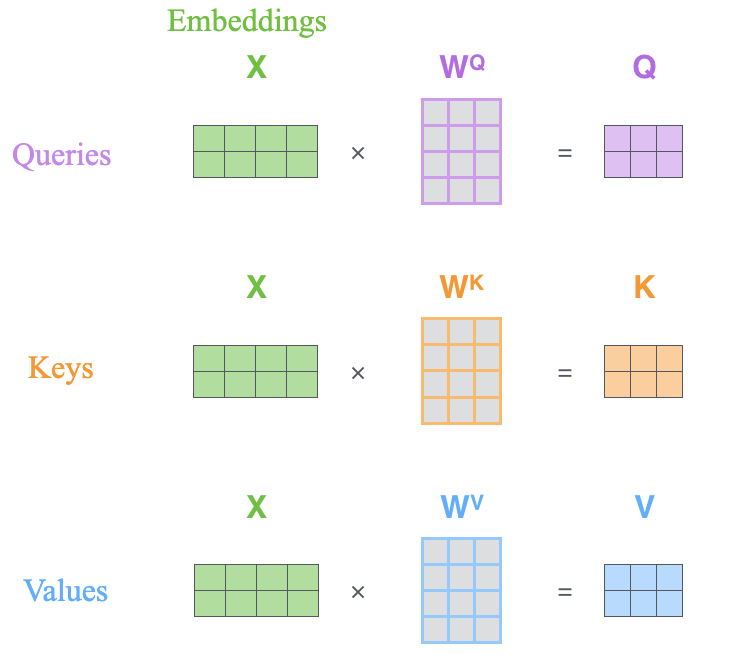

Next, self-attention is calculated as follows:

1. First, we score each word against the target word by taking the dot product of their <font color='pink'>**Query**</font> and <font color='orange'>**Key**</font> vectors. This score determines *attention focus*.
2. We scale the scores (*divide by $8$*, i.e. the square root of the key dimension $d_k = 64$). This leads to having more stable gradients.
3. We apply `Softmax` for normalization.
4. We multiply each <font color='blue'>**Value**</font> vector by its softmax score.
5. Finally, we sum the weighted value vectors to produce the self-attention output.

$$\operatorname{Self-Attention}(Q,K,V)=\operatorname{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V.$$


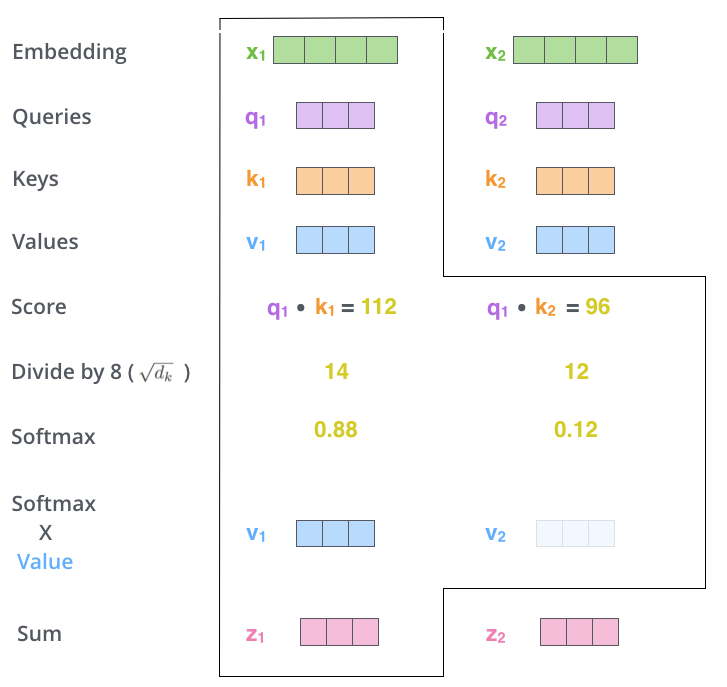


In matrix form we calculate it as follows:

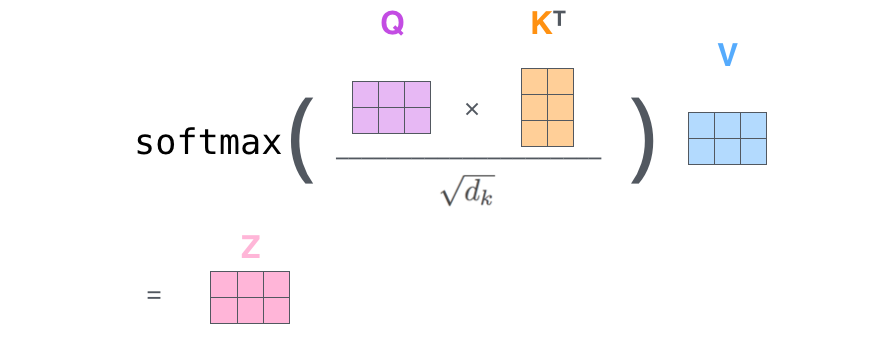

In [ ]:
class MultiHeadAttention(nn.Module):

    NEW_ID = itertools.count()

    def __init__(self, n_heads, dim, src_dim, dropout):
        super().__init__()
        self.layer_id = next(MultiHeadAttention.NEW_ID)
        self.dim = dim
        self.src_dim = src_dim
        self.n_heads = n_heads
        self.dropout = dropout
        assert self.dim % self.n_heads == 0

        self.q_lin = nn.Linear(dim, dim)
        self.k_lin = nn.Linear(src_dim, dim)
        self.v_lin = nn.Linear(src_dim, dim)
        self.out_lin = nn.Linear(dim, dim)

    def forward(self, input, mask, kv=None, use_cache=False):
        """
        Self-attention (if kv is None)
        or attention over source sentence (provided by kv).
        Input is (bs, qlen, dim)
        Mask is (bs, klen) (non-causal) or (bs, klen, klen)
        """
        assert not (use_cache and self.cache is None)


        ##################################
        # 1. Calculation of dimensions
        ##################################

        bs, qlen, dim = input.size()

        # If self-attention
        if kv is None:
            klen = qlen if not use_cache else self.cache["slen"] + qlen
        else:
            klen = kv.size(1)
        assert dim == self.dim, "Dimensions do not match: %s input vs %s configured" % (
            dim,
            self.dim,
        )
        n_heads = self.n_heads
        dim_per_head = dim // n_heads
        mask_reshape = (bs, 1, qlen, klen) if mask.dim() == 3 else (bs, 1, 1, klen)

        ##################################
        # 2. Q, K, V
        ##################################

        def shape(x):
            """  projection """
            # changes size of tensor to (bs, n_heads, *, dim_per_head)
            return x.view(bs, -1, self.n_heads, dim_per_head).transpose(1, 2)


        q = shape(self.q_lin(input))  # (bs, n_heads, qlen, dim_per_head)
        if kv is None:
            k = shape(self.k_lin(input))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v_lin(input))  # (bs, n_heads, qlen, dim_per_head)
        elif not use_cache or self.layer_id not in self.cache:
            k = v = kv
            k = shape(self.k_lin(k))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v_lin(v))  # (bs, n_heads, qlen, dim_per_head)

        ##################################
        # 3. Caching K and V
        ##################################

        if use_cache:
            if self.layer_id in self.cache:
                if kv is None:
                    k_, v_ = self.cache[self.layer_id]
                    k = torch.cat([k_, k], dim=2)  # (bs, n_heads, klen, dim_per_head)
                    v = torch.cat([v_, v], dim=2)  # (bs, n_heads, klen, dim_per_head)
                else:
                    k, v = self.cache[self.layer_id]
            self.cache[self.layer_id] = (k, v)

        ##################################
        # 4. Output from Q, K, V
        ##################################

        # Steps 1 and 2
        q = q / math.sqrt(dim_per_head)  # (bs, n_heads, qlen, dim_per_head)
        scores = torch.matmul(q, k.transpose(2, 3))  # (bs, n_heads, qlen, klen)

        ##################
        # Attention mask (see explanation below)
        ##################

        mask = (
            (mask == 0).view(mask_reshape).expand_as(scores)
        )  # (bs, n_heads, qlen, klen)
        scores.masked_fill_(mask, -float("inf"))  # (bs, n_heads, qlen, klen)

        # Step 3
        weights = F.softmax(scores.float(), dim=-1).type_as(
            scores
        )  # (bs, n_heads, qlen, klen)

        # Add Dropout
        weights = F.dropout(
            weights, p=self.dropout, training=self.training
        )  # (bs, n_heads, qlen, klen)

        # Steps 4 and 5
        context = torch.matmul(weights, v)  # (bs, n_heads, qlen, dim_per_head)

        def unshape(x):
            """  compute context """
            # we use it to change (bs, n_heads, qlen, dim_per_head) tensor
            # into a (bs, qlen, dim) tensor
            return (
                x.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * dim_per_head)
            )
            # tensor.contiguous() will create a copy of the tensor, and
            # the element in the copy will be stored in the memory in a contiguous way.
            # The contiguous() function is usually required when we first transpose() a tensor and then reshape (view) it.

        context = unshape(context)  # (bs, qlen, dim)

        # We save weight if we want to check them
        if TransformerModel.STORE_OUTPUTS and not self.training:
            self.outputs = weights.detach().cpu()

        return self.out_lin(context)

**Multi-head attention** enhances self-attention by providing two key benefits: improved focus on different positions and the creation of multiple representation subspaces. This is accomplished by *using multiple sets* of <font color='pink'>**Query**</font>, <font color='orange'>**Key**</font> and <font color='blue'>**Value**</font> weight matrices, each initialized differently. After calculating self-attention with each head, the resulting matrices are concatenated to form a larger matrix, which is then linearly transformed using a weight matrix ($W^O$) to produce the final output.

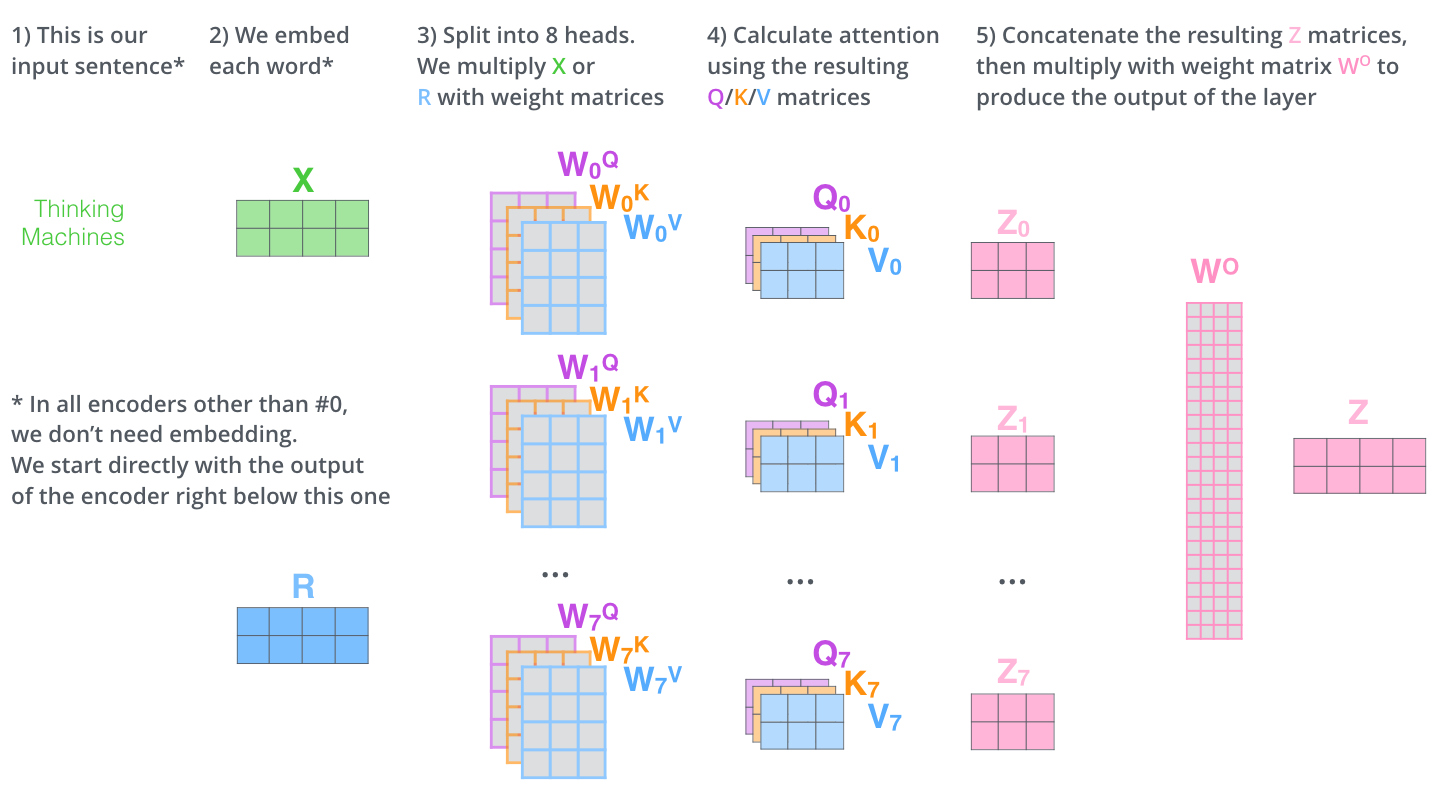

### 2.1.1 Attention mask

It's important to note that the attention mechanism, as described, allows each token to "look" at the entire sequence, which is *undesirable for the decoder*. During generation, we produce one token per step. Access to future tokens during training would lead to information leakage and poor model quality. To prevent this, we apply an **autoregressive mask** during training, setting weights before softmax to $-\infty$ for future tokens, making their softmax probabilities zero.

In [ ]:
def get_masks(slen, lengths, causal):
    """
    Generate hidden states mask, and optionally an attention mask.
    """
    assert lengths.max().item() <= slen
    bs = lengths.size(0)
    alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
    mask = alen < lengths[:, None]

    # attention mask is the same as mask, or triangular inferior attention (causal)
    if causal:
        attn_mask = alen[None, None, :].repeat(bs, slen, 1) <= alen[None, :, None]
    else:
        attn_mask = mask

    # sanity check
    assert mask.size() == (bs, slen)
    assert causal is False or attn_mask.size() == (bs, slen, slen)

    return mask, attn_mask

Example of usage:

In [ ]:
# Example usage
slen = 5  # Sequence length
lengths = torch.tensor([3, 5, 2])  # Example lengths
causal = True # Set to True for causal attention
mask, attn_mask = get_masks(slen, lengths, causal)
print("Mask (causal=True):\n", mask)
print("Attention Mask (causal=True):\n", attn_mask)

Mask (causal=True):
 tensor([[ True,  True,  True, False, False],
        [ True,  True,  True,  True,  True],
        [ True,  True, False, False, False]])
Attention Mask (causal=True):
 tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]],

        [[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]],

        [[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])


As shown in the figure, the attention mask is lower triangular.

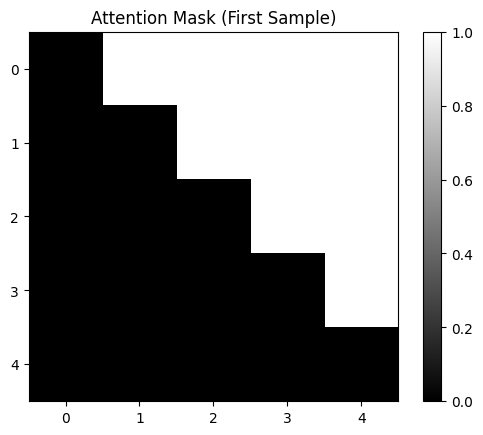

In [ ]:
import matplotlib.pyplot as plt

# Select the first matrix in the batch (index 0)
matrix_to_plot = attn_mask[0].numpy()

# Create the plot
plt.imshow(~matrix_to_plot, cmap='gray', interpolation='nearest')
plt.colorbar()  # Add colorbar for better visualization
plt.title('Attention Mask (First Sample)')
plt.show()

## 2.2 Transformer Layer

Before proceeding, note that for stability each encoder sub-layer (self-attention, feed-forward network) includes
*   a **residual connection**
*    and **layer normalization**.

Also, in the implementation below

*  **dropout** is also used after attention layers (not shown in the figure below).


Visualizing this for self-attention yields:


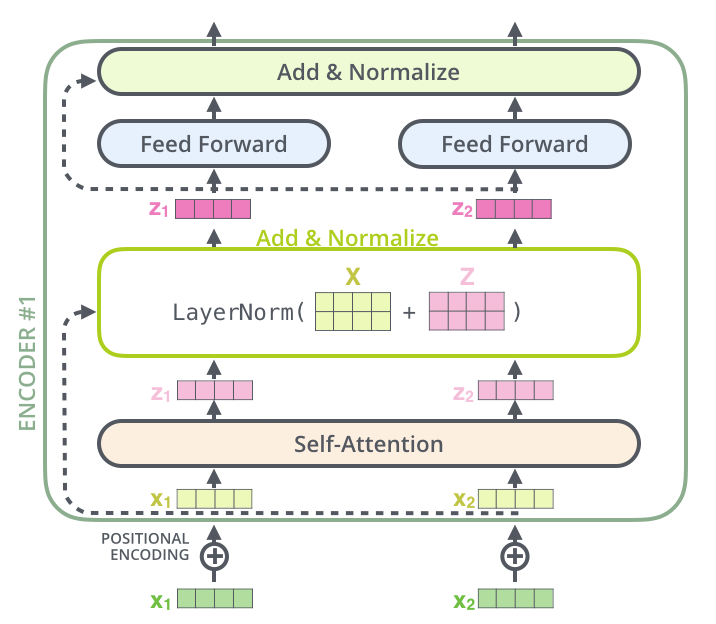

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, params, is_encoder):
        """
        Transformer model (encoder or decoder).
        """
        super().__init__()

        self.is_encoder = is_encoder
        self.is_decoder = not is_encoder

        # model parameters
        self.dim = params["enc_emb_dim"] if is_encoder else params["dec_emb_dim"]  # 512 by default
        self.src_dim = params["enc_emb_dim"]
        self.hidden_dim = self.dim * 4  # 2048 by default
        self.n_heads = params["n_enc_heads"] if is_encoder else params["n_dec_heads"]  # 8 by default
        self.n_layers = params["n_enc_layers"] if is_encoder else params["n_dec_layers"]
        self.dropout = params["dropout"]
        self.attention_dropout = params["attention_dropout"]

        assert (
            self.dim % self.n_heads == 0
        ), "transformer dim must be a multiple of n_heads"

        # MultiHeadAttention
        self.self_attention = MultiHeadAttention(
            self.n_heads,
            self.dim,
            self.dim,
            dropout=self.attention_dropout,
        )

        # LayerNorm
        self.layer_norm1 = nn.LayerNorm(self.dim, eps=1e-12)

        # Decoder has another LayerNorm and MultiHeadAttention
        if self.is_decoder:
            self.layer_norm15 = nn.LayerNorm(self.dim, eps=1e-12)

            # encoder-decoder attention
            self.cross_attention = MultiHeadAttention(
                self.n_heads,
                self.dim,
                self.src_dim,
                dropout=self.attention_dropout,
            )

        # Feed-Forward Network
        self.ffn = TransformerFFN(
            self.dim,
            self.hidden_dim,
            self.dim,
            dropout=self.dropout,
        )

        # Layer Norm
        self.layer_norm2 = nn.LayerNorm(self.dim, eps=1e-12)

    def forward(self, x, attn_mask, src_mask, src_enc, use_cache=False, cache=None):
        tensor = x
        # self attention
        self.self_attention.cache = cache
        attn = self.self_attention(tensor, attn_mask, use_cache=use_cache)
        # dropout
        attn = F.dropout(attn, p=self.dropout, training=self.training)
        # residual connection
        output = tensor + attn
        # layer norm
        output = self.layer_norm1(output)

        # encoder attention (for decoder only)
        if self.is_decoder and src_enc is not None:
            self.cross_attention.cache = cache
            # encoder-decoder attention
            attn = self.cross_attention(tensor, src_mask, kv=src_enc, use_cache=use_cache)
            # dropout
            attn = F.dropout(attn, p=self.dropout, training=self.training)
            # residual connection
            output = output + attn
            # layer norm
            output = self.layer_norm15(output)

        # FFN
        output = output + self.ffn(output) # ffn + residual
        tensor = self.layer_norm2(output) # layer norm
        return tensor

The decoder has a similar structure:

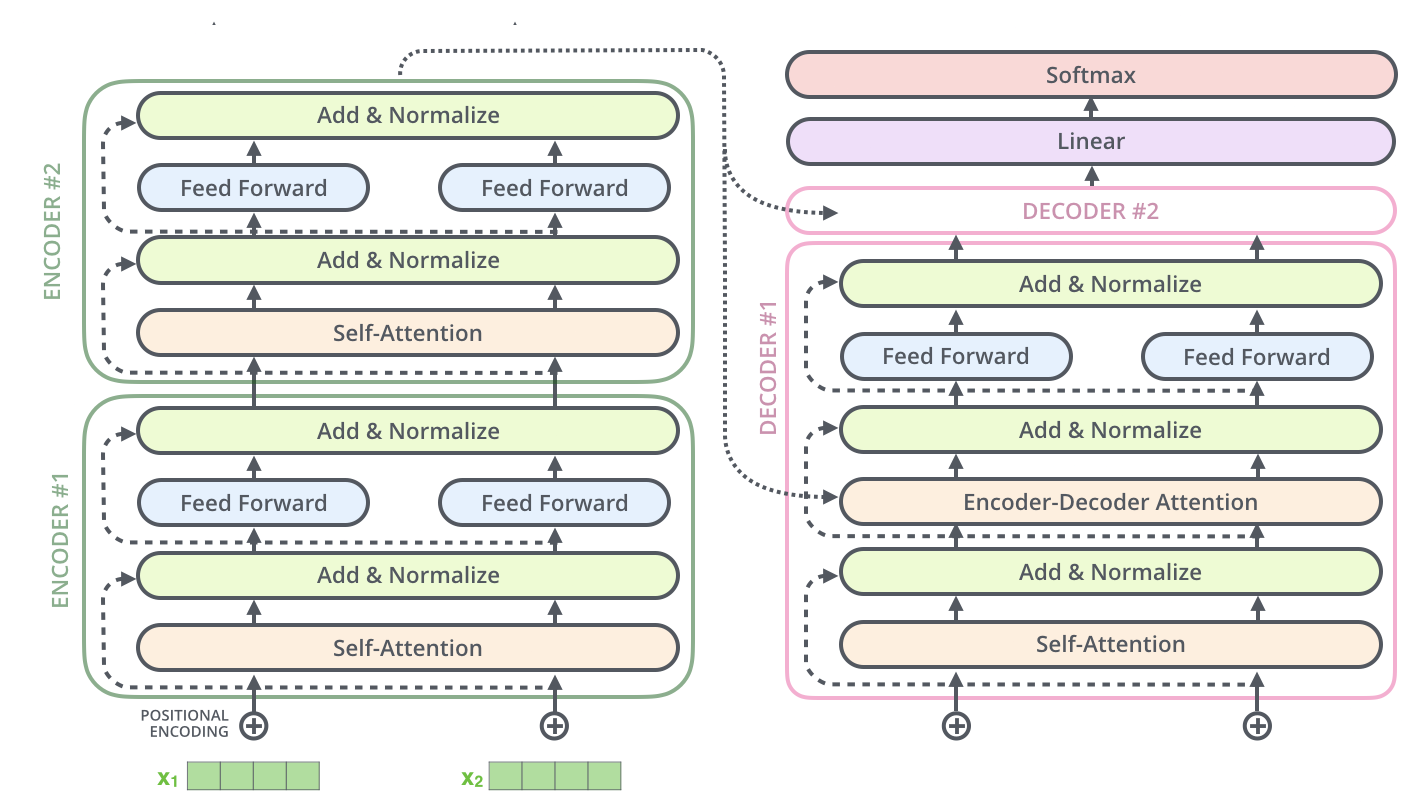

# 3. Transformer model

Due to its length, we omit the Transformer model code. Instead, we download the code directly from

https://raw.githubusercontent.com/facebookresearch/LAWT/main/src/model/transformer.py.



In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/LAWT/main/src/model/transformer.py

from transformer import TransformerModel

--2025-05-05 21:04:14--  https://raw.githubusercontent.com/facebookresearch/LAWT/main/src/model/transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27355 (27K) [text/plain]
Saving to: ‘transformer.py’

transformer.py      100%[===================>]  26.71K  --.-KB/s    in 0.002s  

2025-05-05 21:04:14 (11.2 MB/s) - ‘transformer.py’ saved [27355/27355]



*   **Remark**. To capture word order, the Transformer adds **positional encodings** to input embeddings. These learnable encodings help the model understand word positions and relationships, creating meaningful distance information when embeddings are used in attention.



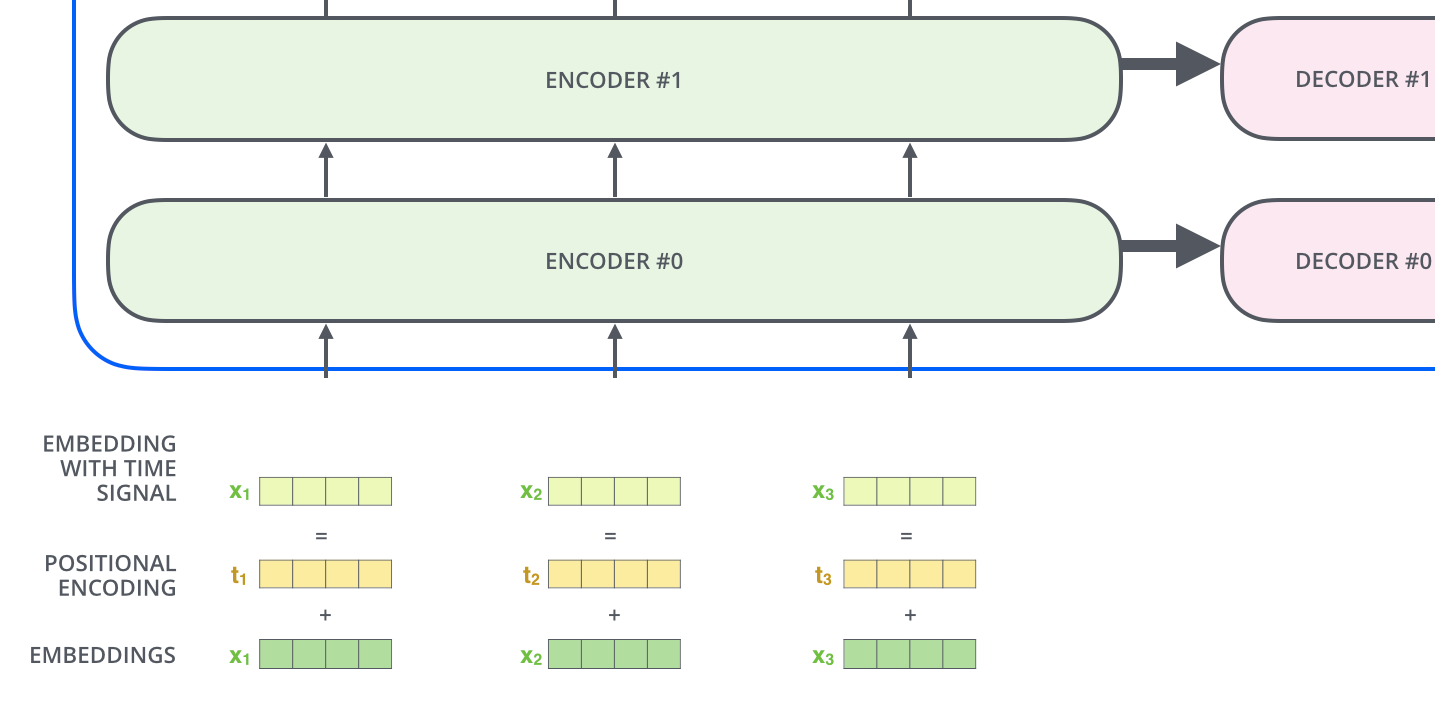

# 4. Load Models

## 4.1 Dictionary and Embeddings

We begin by initializing the encoders and embedding dictionaries.

In [ ]:
# Initialize the encoder
encoder_params = {
    "max_encoder_dimension": 100
}

encoder_prec = 2
encdoder_max_exponent = 16

input_encoder = FPSymbol(params=encoder_params, precision=encoder_prec, max_exponent=encdoder_max_exponent)

decoder_params = {
    "max_encoder_dimension": 100
}
decoder_prec =  2
decoder_base_int = 1000
output_encoder = Positional(params=decoder_params, prec=decoder_prec, base_int=decoder_base_int)

Embedding Dictionaries:

In [ ]:
SPECIAL_WORDS = ["<s>", "</s>", "<pad>", "(", ")"] + [
    f"<SPECIAL_{i}>" for i in range(10)
] + ['T', 'A', 'D', 'M', 'E', 'F', 'I']

common_symbols = ['+', '-', '10^', '.', '|']
words = SPECIAL_WORDS + common_symbols + sorted(list(
            set(output_encoder.symbols + input_encoder.symbols)
        ))
id2word = {i: s for i, s in enumerate(words)}
word2id = {s: i for i, s in id2word.items()}
print(len(id2word))

30329


## 4.2 Transformer's Encoder

The parameters are taken from https://github.com/facebookresearch/LAWT/blob/main/sweeps/eigenvalues.json

In [ ]:
from collections import namedtuple

N_MAX_POSITIONS = 4096  # maximum input sequence length

# Define a Parameters namedtuple for the model configuration
Params = namedtuple('Params', [
    'n_words', 'eos_index', 'pad_index', 'enc_emb_dim', 'dec_emb_dim',
    'n_enc_heads', 'n_dec_heads', 'n_enc_layers', 'n_dec_layers',
    'dropout', 'attention_dropout', 'sinusoidal_embeddings',
    'share_inout_emb', 'fp16', 'batch_size'
])

# Set up the transformer parameters
params = Params(
    n_words = len(id2word),
    eos_index = 0,
    pad_index = 1,

    fp16 = True,

    # Encoder parameters
    enc_emb_dim = 512,
    n_enc_layers = 6,
    n_enc_heads = 8,

    # Decoder parameters
    dec_emb_dim = 512,
    n_dec_layers = 1,
    n_dec_heads = 8,
    dropout = 0,
    attention_dropout = 0,

    batch_size = 64,

    sinusoidal_embeddings = False,
    share_inout_emb = True,
)

We will now observe the Encoder architecture.






In [ ]:
encoder = TransformerModel(params=params, id2word=id2word, is_encoder =True, with_output=False)
encoder.eval()

TransformerModel(
  (position_embeddings): Embedding(4096, 512)
  (embeddings): Embedding(30329, 512, padding_idx=1)
  (layer_norm_emb): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attention): MultiHeadAttention(
        (q_lin): Linear(in_features=512, out_features=512, bias=True)
        (k_lin): Linear(in_features=512, out_features=512, bias=True)
        (v_lin): Linear(in_features=512, out_features=512, bias=True)
        (out_lin): Linear(in_features=512, out_features=512, bias=True)
      )
      (layer_norm1): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (ffn): TransformerFFN(
        (lin1): Linear(in_features=512, out_features=2048, bias=True)
        (lin2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (layer_norm2): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    )
  )
)

## 4.3 Transformer's Decoder

The Decoder structure:

In [ ]:
decoder = TransformerModel(params=params, id2word=id2word, is_encoder =False, with_output=True)
decoder.eval()

TransformerModel(
  (position_embeddings): Embedding(4096, 512)
  (embeddings): Embedding(30329, 512, padding_idx=1)
  (layer_norm_emb): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attention): MultiHeadAttention(
        (q_lin): Linear(in_features=512, out_features=512, bias=True)
        (k_lin): Linear(in_features=512, out_features=512, bias=True)
        (v_lin): Linear(in_features=512, out_features=512, bias=True)
        (out_lin): Linear(in_features=512, out_features=512, bias=True)
      )
      (layer_norm1): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (layer_norm15): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (cross_attention): MultiHeadAttention(
        (q_lin): Linear(in_features=512, out_features=512, bias=True)
        (k_lin): Linear(in_features=512, out_features=512, bias=True)
        (v_lin): Linear(in_features=512, out_features=512, bias=True)
        (out_lin):

## 4.4 Load weights

In [ ]:
# Load the state dictionary from the checkpoint file
checkpoint = torch.load("best-valid_numeric_beam_acc.pth", map_location=torch.device('cpu'))

# Print the available keys in the checkpoint file
print(checkpoint.keys())

encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
print("Parameters loaded successfully.")


dict_keys(['epoch', 'n_total_iter', 'best_metrics', 'best_stopping_criterion', 'params', 'encoder', 'decoder', 'optimizer', 'scaler'])
Parameters loaded successfully.


## 4.5 Experiment

We begin by generating a $5\times 5$ matrix with random values between $-10$ and $10$.

In [ ]:
# Create a 5x5 matrix
a, b = 5, 5
np.random.seed(42)  # Set the random seed for reproducibility
matrix = 20 * np.random.rand(a, b) - 10  # Example matrix with random values in [-10,10]
matrix = (matrix + matrix.T) / 2
print("Original Matrix:")
print(matrix)

# Encode the matrix
encoded_matrix = input_encoder.encode(matrix)
print("\nEncoded Matrix:")
print(encoded_matrix)

Original Matrix:
[[-2.50919762  1.06708827 -2.47421564 -2.17937006 -2.32128465]
 [ 1.06708827 -8.83832776  8.36085998 -0.94642745 -1.52433562]
 [-2.47421564  8.36085998  6.64885282 -2.62904458 -5.26030384]
 [-2.17937006 -0.94642745 -2.62904458 -1.36109963 -3.42409017]
 [-2.32128465 -1.52433562 -5.26030384 -3.42409017 -0.87860032]]

Encoded Matrix:
['V5', 'V5', 'N-251e7', 'N107e7', 'N-247e7', 'N-218e7', 'N-232e7', 'N107e7', 'N-884e7', 'N836e7', 'N-946e6', 'N-152e7', 'N-247e7', 'N836e7', 'N665e7', 'N-263e7', 'N-526e7', 'N-218e7', 'N-946e6', 'N-263e7', 'N-136e7', 'N-342e7', 'N-232e7', 'N-152e7', 'N-526e7', 'N-342e7', 'N-879e6']


We transform Encoded Matrix into a LongTensor.

In [ ]:
# Replace matrix values with numerical IDs using word2id
numerical_matrix = []
for value in encoded_matrix:
    numerical_matrix.append(word2id[str(value)])

# Convert the numerical matrix to a PyTorch LongTensor
long_tensor = torch.tensor(numerical_matrix, dtype=torch.long).unsqueeze(1)

print("Original Encoded Matrix:\n", encoded_matrix)
print("\nNumerical Matrix:\n", numerical_matrix)
print("\nLongTensor:\n", long_tensor)
print(long_tensor.shape)


Original Encoded Matrix:
 ['V5', 'V5', 'N-251e7', 'N107e7', 'N-247e7', 'N-218e7', 'N-232e7', 'N107e7', 'N-884e7', 'N836e7', 'N-946e6', 'N-152e7', 'N-247e7', 'N836e7', 'N665e7', 'N-263e7', 'N-526e7', 'N-218e7', 'N-946e6', 'N-263e7', 'N-136e7', 'N-342e7', 'N-232e7', 'N-152e7', 'N-526e7', 'N-342e7', 'N-879e6']

Numerical Matrix:
 [30274, 30274, 3674, 15854, 3609, 3142, 3368, 15854, 13871, 27598, 14869, 2079, 3609, 27598, 24843, 3867, 8104, 3142, 14869, 3867, 1821, 5140, 3368, 2079, 8104, 5140, 13789]

LongTensor:
 tensor([[30274],
        [30274],
        [ 3674],
        [15854],
        [ 3609],
        [ 3142],
        [ 3368],
        [15854],
        [13871],
        [27598],
        [14869],
        [ 2079],
        [ 3609],
        [27598],
        [24843],
        [ 3867],
        [ 8104],
        [ 3142],
        [14869],
        [ 3867],
        [ 1821],
        [ 5140],
        [ 3368],
        [ 2079],
        [ 8104],
        [ 5140],
        [13789]])
torch.Size([27, 1])


We apply the Encoder.

In [ ]:
"""
Inputs (of the Encoder):
    `x` LongTensor(slen, bs), containing word indices
    `lengths` LongTensor(bs), containing the length of each sentence
    `causal` Boolean, if True, the attention is only done over previous hidden states
    `positions` LongTensor(slen, bs), containing word positions
"""
lengths_tensor = torch.tensor([long_tensor.shape[0]], dtype=torch.long)
print(lengths_tensor)

encoded = encoder("fwd", x=long_tensor, lengths=lengths_tensor, causal=False)
print(encoded.shape)
print(encoded)

tensor([27])
torch.Size([27, 1, 512])
tensor([[[-0.0635, -0.0720, -0.0567,  ...,  0.0441, -0.0440,  0.0052]],

        [[-0.9160,  0.1113, -0.0755,  ...,  1.3455, -0.0339, -0.0044]],

        [[-0.0249, -0.0526, -0.0417,  ..., -0.2364, -0.0015, -0.0346]],

        ...,

        [[-0.0607, -0.4502, -0.4707,  ..., -0.1673,  0.0098, -0.0798]],

        [[-0.0709, -0.3028, -0.1714,  ..., -0.4499, -0.0234, -0.0772]],

        [[-0.1020,  0.3779,  0.0546,  ..., -0.2915, -0.0551,  0.0525]]],
       grad_fn=<TransposeBackward0>)


We generate an answer using the Decoder.

In [ ]:
dec_length = torch.tensor([encoded.shape[0]], dtype=torch.long)

generated, gen_len = decoder.generate(
    src_enc=encoded.transpose(0, 1),
    src_len=dec_length,
)

print(generated)

tensor([[    0],
        [30274],
        [30229],
        [   22],
        [   86],
        [ 1028],
        [   22],
        [   44],
        [ 1028],
        [   23],
        [   40],
        [ 1028],
        [   23],
        [  112],
        [ 1028],
        [   23],
        [   45],
        [ 1028],
        [    0]])


We convert the generated LongTensor to P1000 encoding.

In [ ]:
generated_list = []
for i in range(generated.shape[0]):
  generated_list.append([id2word[idx.item()] for idx in generated[i]][0])
generated_list

['<s>',
 'V5',
 'V1',
 '+',
 '150',
 'E-1',
 '+',
 '112',
 'E-1',
 '-',
 '109',
 'E-1',
 '-',
 '174',
 'E-1',
 '-',
 '113',
 'E-1',
 '<s>']

We decode the generated matrix.

In [ ]:
# Decode the matrix
answer = output_encoder.decode(generated_list[1:])
print("\nDecoded Matrix:")
print(answer)


Decoded Matrix:
[[ 15. ]
 [ 11.2]
 [-10.9]
 [-17.4]
 [-11.3]]


The eigenvalues of the original matrix:

In [ ]:
# Calculate eigenvalues
eigenvalues = np.linalg.eigvals(matrix)

print("Eigenvalues of the matrix:")
np.sort(eigenvalues)[::-1]

Eigenvalues of the matrix:


array([ 12.67285225,   1.99776982,  -0.26384993,  -8.17938048,
       -13.16576416])

Transformers are powerful but non-trivial. Creating a well-performing Transformer model is a time-consuming endeavor demanding considerable patience. Effective training can extend over days or even weeks. When available, <font color='red'>utilize established parameters from research articles</font>.

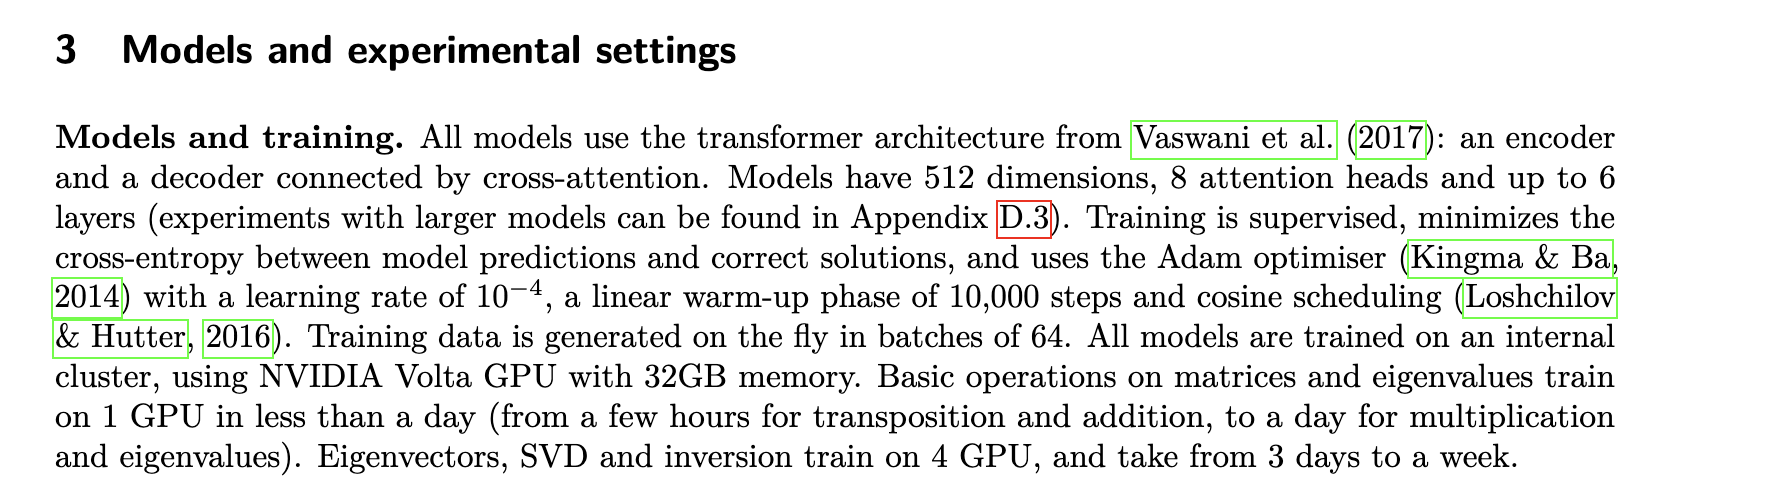